In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA

**Ex 1**

In [2]:
mean = np.array([5, 10, 2])
cov = np.array([[3, 2, 2],
                [2, 10, 1],
                [2, 1, 2]])

X = np.random.multivariate_normal(mean, cov, size=500)

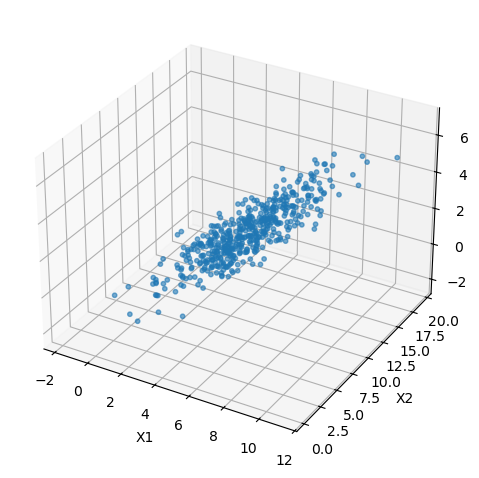

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=10, alpha=0.6)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.tight_layout()

In [4]:
X_centered = X - np.mean(X, axis=0)

In [5]:
N = X.shape[0]
Sigma = (X_centered.T @ X_centered) / N

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(Sigma)

In [7]:
idx = np.argsort(eigenvalues)[::-1]

eigenvalues_sorted = eigenvalues[idx]
eigenvectors_sorted = eigenvectors[:, idx]

eigenvalues_sorted

array([10.41913507,  4.00602073,  0.3947017 ])

In [8]:
explained_variance_ratio = eigenvalues_sorted / np.sum(eigenvalues_sorted)
explained_variance_ratio

array([0.70305231, 0.27031439, 0.0266333 ])

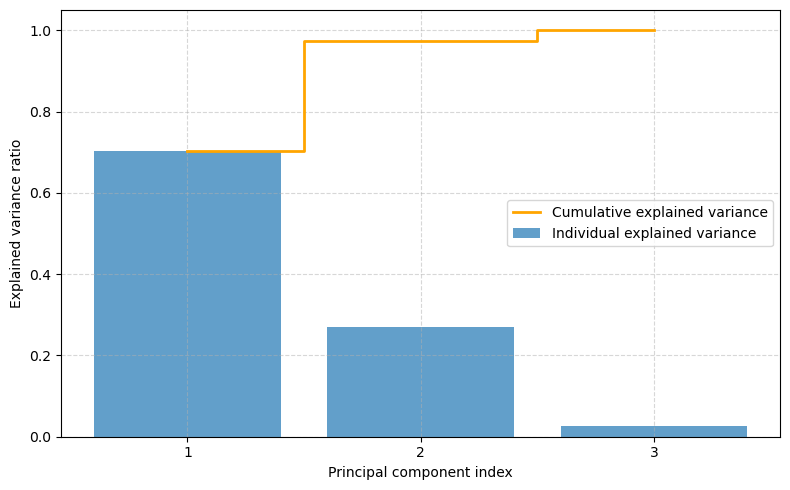

In [9]:
cumulative_variance = np.cumsum(explained_variance_ratio)

k = np.arange(1, len(eigenvalues_sorted) + 1)

plt.figure(figsize=(8, 5))

plt.bar(k, explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(k, cumulative_variance, where='mid', linewidth=2, label='Cumulative explained variance', color='orange')

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.xticks(k)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

In [10]:
Z = X_centered @ eigenvectors_sorted

pc_index = 2
contamination = 0.1

pc_values = Z[:, pc_index]
mean_pc = np.mean(pc_values)

deviation = np.abs(pc_values - mean_pc)

In [11]:
threshold = np.quantile(deviation, 1 - contamination)

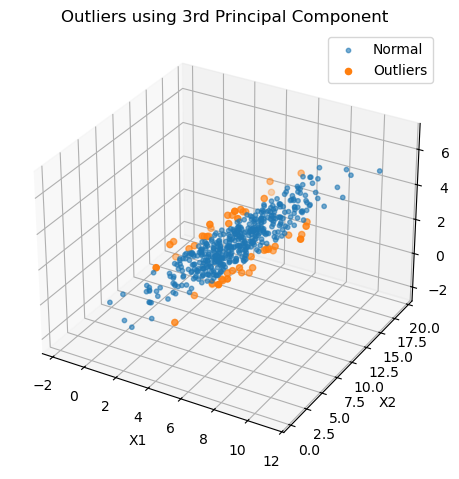

In [12]:
labels_pc3 = (deviation > threshold).astype(int)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[labels_pc3 == 0, 0],
           X[labels_pc3 == 0, 1],
           X[labels_pc3 == 0, 2],
           s=10, alpha=0.6, label='Normal')

ax.scatter(X[labels_pc3 == 1, 0],
           X[labels_pc3 == 1, 1],
           X[labels_pc3 == 1, 2],
           s=20, label='Outliers')

ax.set_title('Outliers using 3rd Principal Component')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()

plt.tight_layout()

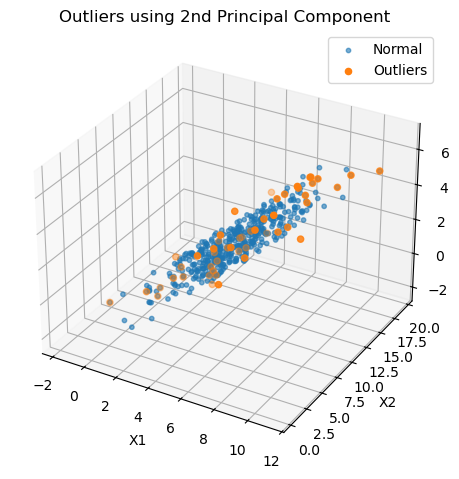

In [13]:
pc_index = 1
contamination = 0.1

pc_values = Z[:, pc_index]
mean_pc = np.mean(pc_values)

deviation = np.abs(pc_values - mean_pc)

threshold = np.quantile(deviation, 1 - contamination)

labels_pc2 = (deviation > threshold).astype(int)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[labels_pc3 == 0, 0],
           X[labels_pc3 == 0, 1],
           X[labels_pc3 == 0, 2],
           s=10, alpha=0.6, label='Normal')

ax.scatter(X[labels_pc2 == 1, 0],
           X[labels_pc2 == 1, 1],
           X[labels_pc2 == 1, 2],
           s=20, label='Outliers')

ax.set_title('Outliers using 2nd Principal Component')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()

plt.tight_layout()

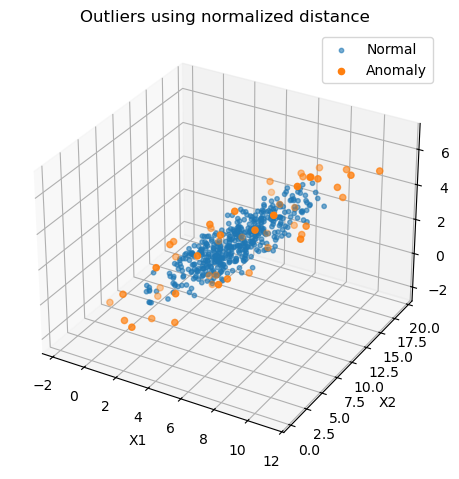

In [14]:
X_centered = X - np.mean(X, axis=0)
N = X_centered.shape[0]

Sigma = (X_centered.T @ X_centered) / N

eigenvalues, P = np.linalg.eig(Sigma)

idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
P = P[:, idx]

Delta = np.diag(eigenvalues)

X_prime = X_centered @ P

Delta_inv_sqrt = np.diag(1.0 / np.sqrt(eigenvalues))
X_normalized = X_prime @ Delta_inv_sqrt

centroid = np.mean(X_normalized, axis=0)

scores = np.sum((X_normalized - centroid)**2, axis=1)

contamination = 0.1
threshold = np.quantile(scores, 1 - contamination)

labels = (scores > threshold).astype(int)   # 1 = anomaly, 0 = normal

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[labels == 0, 0],
           X[labels == 0, 1],
           X[labels == 0, 2],
           s=10, alpha=0.6, label='Normal')

ax.scatter(X[labels == 1, 0],
           X[labels == 1, 1],
           X[labels == 1, 2],
           s=20, label='Anomaly')

ax.set_title('Outliers using normalized distance')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()

plt.tight_layout()

**Ex 2**

In [15]:
from scipy.io import loadmat

data = loadmat('shuttle.mat')

In [16]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [17]:
X = data['X']
y = data['y']

In [18]:
contamination_rate = np.sum(y) / len(y)
contamination_rate

np.float64(0.0715114976475141)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

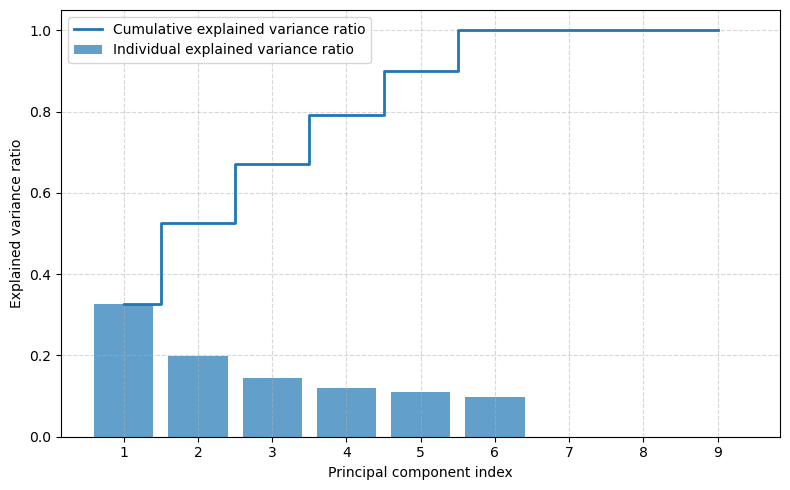

In [20]:
pca = PCA(contamination=contamination_rate)
pca.fit(X_train_std)

explained_var = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_

cum_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(8, 5))
n_comp = len(explained_var_ratio)
components = np.arange(1, n_comp + 1)

plt.bar(components, explained_var_ratio, alpha=0.7, label='Individual explained variance ratio')
plt.step(components, cum_var_ratio, where='mid', linewidth=2, label='Cumulative explained variance ratio')

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.xticks(components)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import balanced_accuracy_score

scores_train_pca = pca.decision_function(X_train)
y_pred_train_pca = pca.labels_

scores_test_pca = pca.decision_function(X_test_std)
y_pred_test_pca = pca.predict(X_test_std)

bacc_train_pca = balanced_accuracy_score(y_train, y_pred_train_pca)
bacc_test_pca  = balanced_accuracy_score(y_test, y_pred_test_pca)

print("PCA - Balanced Accuracy:")
print(f"Train: {bacc_train_pca:.4f}\n Test: {bacc_test_pca:.4f}")

PCA - Balanced Accuracy:
Train: 0.9728
 Test: 0.9749


In [22]:
kpca = KPCA(contamination=contamination_rate, kernel='rbf')
kpca.fit(X_train_std)

scores_train_kpca = kpca.decision_function(X_train_std)
y_pred_train_kpca = kpca.labels_

In [23]:
scores_test_kpca = kpca.decision_function(X_test_std)
y_pred_test_kpca = kpca.predict(X_test_std)

bacc_train_kpca = balanced_accuracy_score(y_train, y_pred_train_kpca)
bacc_test_kpca  = balanced_accuracy_score(y_test, y_pred_test_kpca)

print("KPCA - Balanced Accuracy:")
print(f"Train: {bacc_train_kpca:.4f}\n Test: {bacc_test_kpca:.4f}")

KPCA - Balanced Accuracy:
Train: 0.6374
 Test: 0.7168


**Ex 3**

In [24]:
data = loadmat('shuttle.mat')

X = data['X']
y = data['y']

contamination_rate = np.sum(y) / len(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
X_test_norm  = scaler.transform(X_test)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input

In [28]:
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Sequential([
            Input(shape=(input_dim,)),
            layers.Dense(8, activation='relu'),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])

        self.decoder = Sequential([
            Input(shape=(3,)),
            layers.Dense(5, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(9, activation='sigmoid')
        ])

    def call(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [29]:
input_dim = X_train_norm.shape[1]
autoencoder = Autoencoder(input_dim)

autoencoder.compile(optimizer='adam', loss='mse')

In [30]:
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=100,
    batch_size=1024,
    validation_data=(X_test_norm, X_test_norm)
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - val_loss: 0.0215
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - val_loss: 0.0200
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0109
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

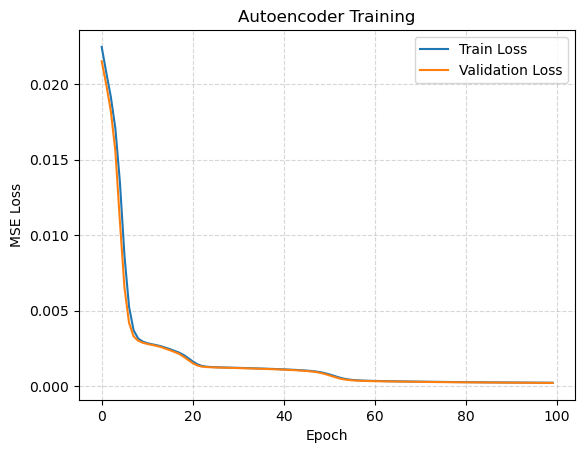

In [31]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [32]:
X_train_pred = autoencoder.predict(X_train_norm)
X_test_pred = autoencoder.predict(X_test_norm)

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step


In [33]:
reconstruction_error_train = np.mean((X_train_norm - X_train_pred)**2, axis=1)
reconstruction_error_test = np.mean((X_test_norm - X_test_pred)**2, axis=1)

In [34]:
threshold = np.quantile(reconstruction_error_train, 1-contamination_rate)

In [35]:
y_pred_train = (reconstruction_error_train > threshold).astype(int)
y_pred_test = (reconstruction_error_test > threshold).astype(int)

In [36]:
ba_train = balanced_accuracy_score(y_train, y_pred_train)
ba_test = balanced_accuracy_score(y_test, y_pred_test)

In [37]:
print("Autoencoder - Balanced Accuracy:")
print(f"Train: {ba_train:.4f}")
print(f"Test : {ba_test:.4f}")

Autoencoder - Balanced Accuracy:
Train: 0.8354
Test : 0.8256


**Ex 4**

In [38]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [39]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [40]:
noise_factor = 0.35

X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape)
X_train_noisy = tf.clip_by_value(X_train_noisy, 0.0, 1.0)

X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)
X_test_noisy = tf.clip_by_value(X_test_noisy, 0.0, 1.0)

In [41]:
class ConvAutoencoder(Model):
    def __init__(self, input_dim=(28,28,1)):
        super(ConvAutoencoder, self).__init__()

        self.encoder = Sequential([
            layers.Input(shape=input_dim),
            layers.Conv2D(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            layers.Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = Sequential([
            layers.Input(shape=(7,7,4)),
            layers.Conv2DTranspose(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(filters=8, kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid')
        ])
        
    def call(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [42]:
autoencoder = ConvAutoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

In [43]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, X_test)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0265 - val_loss: 0.0040
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021 - val_loss: 0.0020


In [44]:
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [45]:
reconstruction_error_train = np.mean((X_train - X_train_pred)**2, axis=(1, 2, 3))
reconstruction_error_test = np.mean((X_test - X_test_pred)**2, axis=(1, 2, 3))

In [46]:
threshold = np.mean(reconstruction_error_train) + np.std(reconstruction_error_train)

y_pred_test = (reconstruction_error_test > threshold).astype(int)

In [47]:
X_test_noisy_pred = autoencoder.predict(X_test_noisy)
reconstruction_error_test_noisy = np.mean((X_test_noisy - X_test_noisy_pred)**2, axis=(1,2,3))
y_pred_test_noisy = (reconstruction_error_test_noisy > threshold).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [49]:
y_true = np.concatenate([
    np.zeros(len(y_pred_test)),
    np.ones(len(y_pred_test_noisy))
])

y_pred = np.concatenate([
    y_pred_test,
    y_pred_test_noisy
])

BA = balanced_accuracy_score(y_true, y_pred)

print(f"Balanced accuracy: {BA:.4f}")

Balanced accuracy: 0.9399


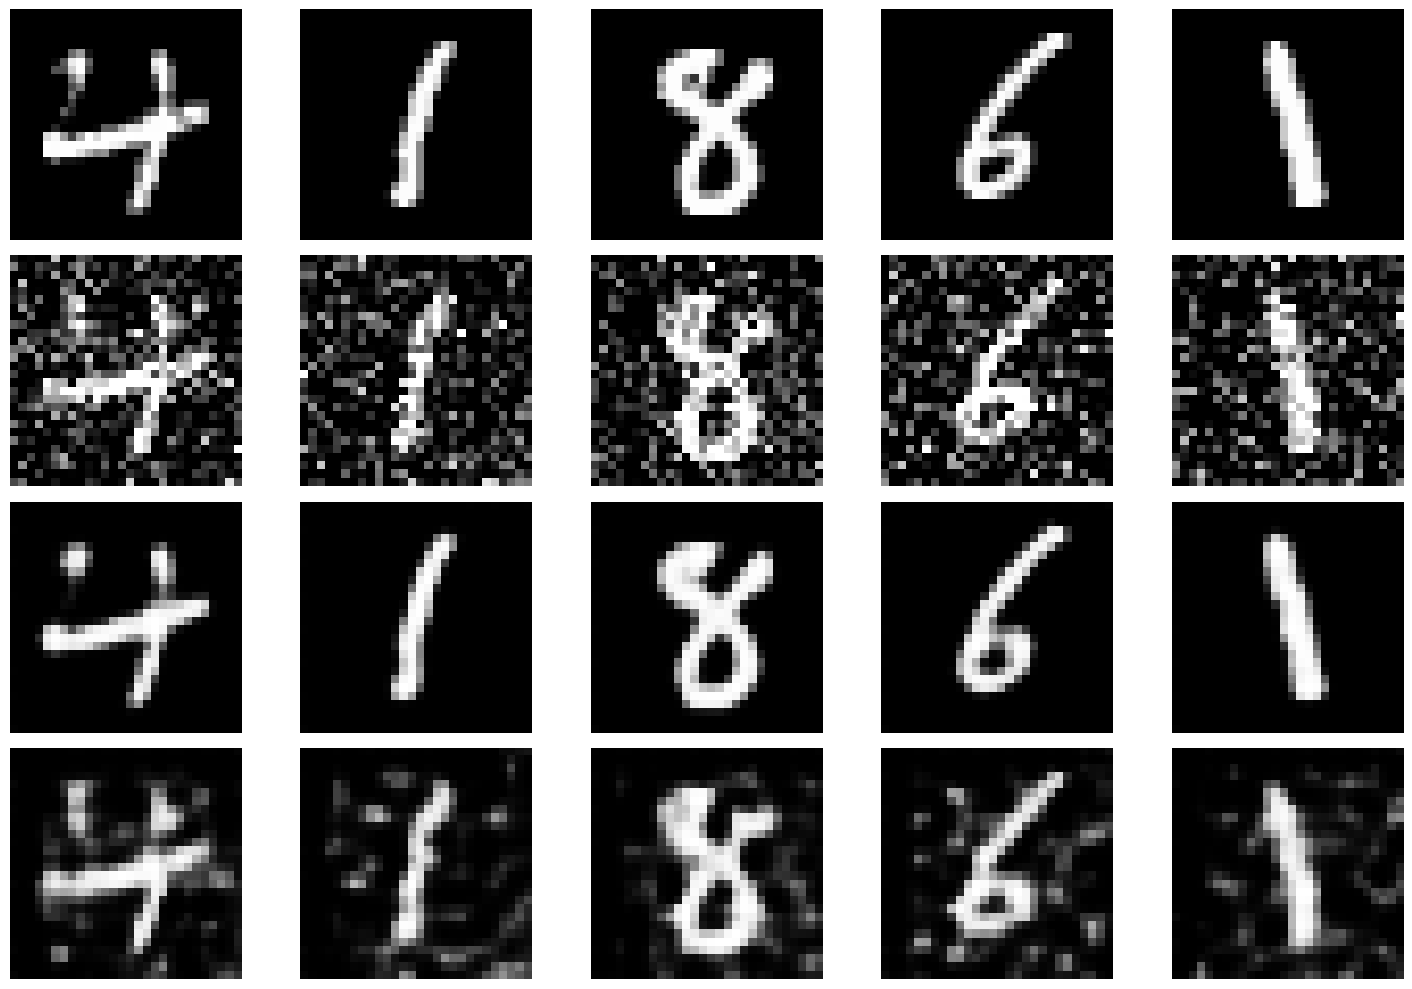

In [50]:
n_images = 5
idx = np.random.choice(len(X_test), n_images, replace=False)

fig, axes = plt.subplots(4, n_images, figsize=(15, 10))

for i, id_ in enumerate(idx):
    axes[0, i].imshow(tf.squeeze(X_test[id_]), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(tf.squeeze(X_test_noisy[id_]), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(tf.squeeze(X_test_pred[id_]), cmap='gray')
    axes[2, i].axis('off')

    axes[3, i].imshow(tf.squeeze(X_test_noisy_pred[id_]), cmap='gray')
    axes[3, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Noisy", fontsize=12)
axes[2, 0].set_ylabel("Reconstructed (original)", fontsize=12)
axes[3, 0].set_ylabel("Reconstructed (noisy)", fontsize=12)

plt.tight_layout()
plt.show()

In [51]:
denoise_autoencoder = ConvAutoencoder()
denoise_autoencoder.compile(optimizer='adam', loss='mse')

In [52]:
denoise_history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_noisy, X_test)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0083 - val_loss: 0.0082


In [53]:
X_test_pred = autoencoder.predict(X_test)
X_test_noisy_pred = autoencoder.predict(X_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


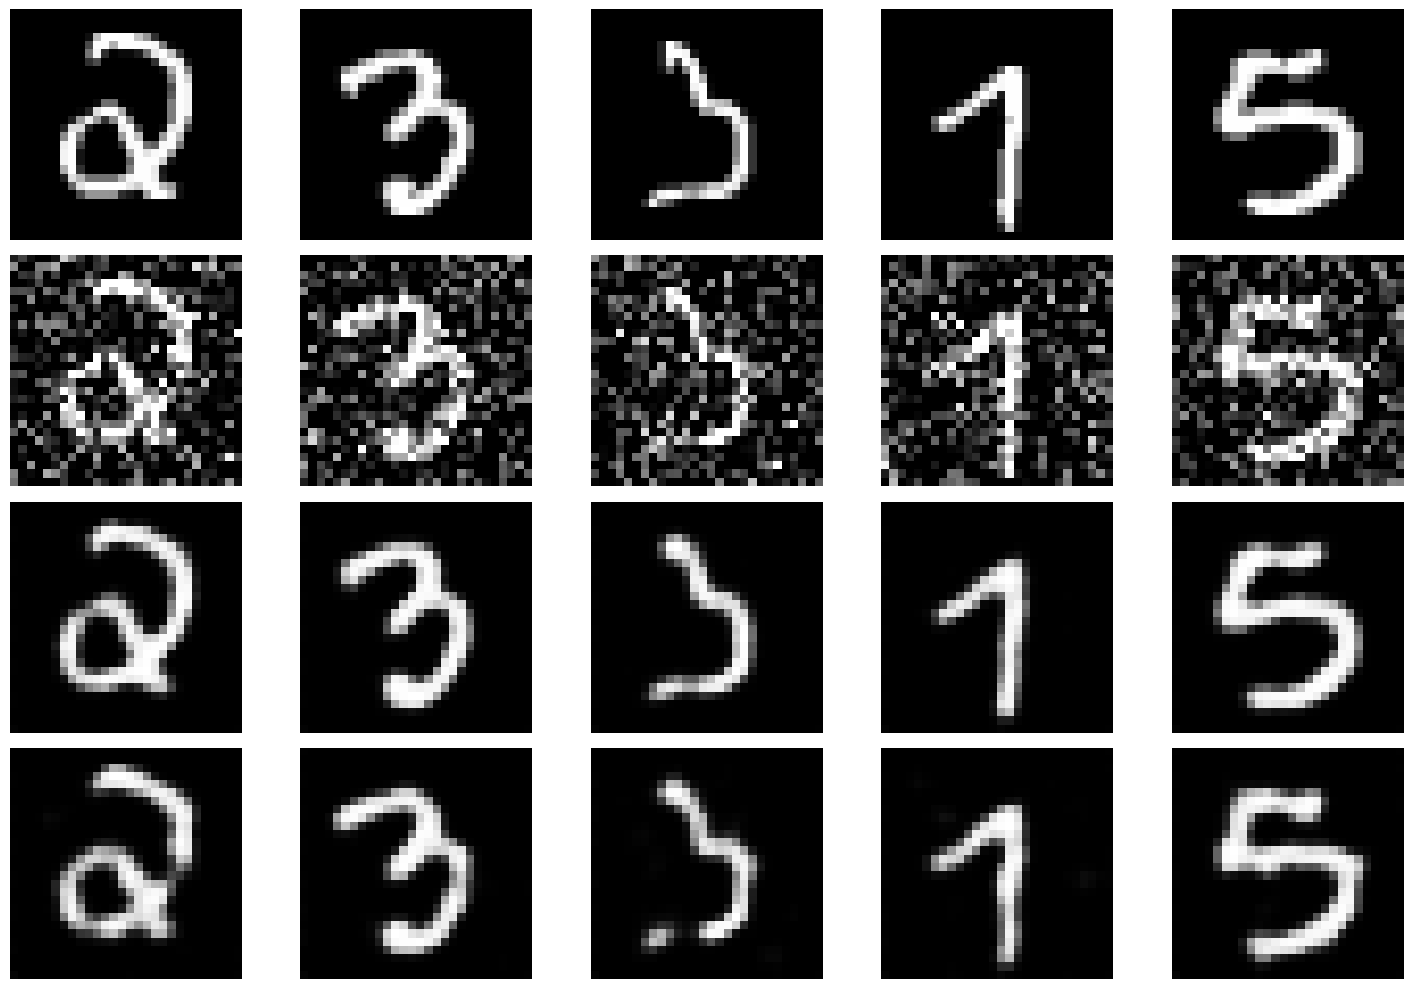

In [54]:
n_images = 5
idx = np.random.choice(len(X_test), n_images, replace=False)

fig, axes = plt.subplots(4, n_images, figsize=(15, 10))

for i, id_ in enumerate(idx):
    axes[0, i].imshow(tf.squeeze(X_test[id_]), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(tf.squeeze(X_test_noisy[id_]), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(tf.squeeze(X_test_pred[id_]), cmap='gray')
    axes[2, i].axis('off')

    axes[3, i].imshow(tf.squeeze(X_test_noisy_pred[id_]), cmap='gray')
    axes[3, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Noisy", fontsize=12)
axes[2, 0].set_ylabel("Reconstructed (original)", fontsize=12)
axes[3, 0].set_ylabel("Reconstructed (noisy)", fontsize=12)

plt.tight_layout()
plt.show()